# Sentiment Analysis on twitter data

### Reading the input

In [19]:
import pandas as pd
df=pd.read_csv('sample_data.csv', sep=',')
df=df.drop(df.columns[0], axis=1)

Now we will take a look at the data.

In [20]:
df.shape

(2648, 5)

In [21]:
df.head()

,id_str,text,created_at,polarity,user_location
0,1161743655130058753,@ImranKhanPTI please use the trend on both twi...,2019-08-14 20:57:26,0,"Malir Cantonment, Pakistan"
1,1161743655713038340,Vic is headed to recovery. Took a bit longer ...,2019-08-14 20:57:26,0,"Walterboro, SC"
2,1161743656056844288,RT @w_terrence: I never experienced racism &am...,2019-08-14 20:57:26,0,"Tennessee, USA"
3,1161743656627396609,Come see me tonight! https://t.co/BkR0sd5dol,2019-08-14 20:57:26,0,Texas
4,1161743656786767873,"https://t.co/F8fTkbqi5M\nBest place to go,got ...",2019-08-14 20:57:26,1,chattanooga tn


### Preprocessing

In [22]:
df = df.drop_duplicates('text')

In [23]:
df['text'][:10]

0    @ImranKhanPTI please use the trend on both twi...
1    Vic is headed to recovery.  Took a bit longer ...
2    RT @w_terrence: I never experienced racism &am...
3        Come see me tonight!  https://t.co/BkR0sd5dol
4    https://t.co/F8fTkbqi5M\nBest place to go,got ...
5    Wow.. this hit d spot.. \n#neededtoshare https...
6    RT @ETrainn71: Saw this on Facebook &amp; Ill ...
7    RT @marte3001: The DJ Space performance video ...
8    RT @seanmdav: Did Mark Zuckerberg Lie Under Oa...
9       Time for a revolution? https://t.co/SSu7Grd6Cg
Name: text, dtype: object

In [24]:
df.isna().sum()

id_str             0
text               0
created_at         0
polarity           0
user_location    466
dtype: int64

We can eliminate those rows with nan in their Location column, since we can aquire more data from twitter. However, here we keep them all.

In [25]:
df['polarity'].value_counts()

 0    1657
 1     249
-1      49
Name: polarity, dtype: int64

#### Text cleaning

In [26]:
import re
def data_cleaner(text):
    text = re.sub(r'&amp', '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+:', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = re.sub(r'http?:\/\/\S+', '', text)
    text = text.lower()
    return text

In [27]:
df['text'] = df['text'].apply(data_cleaner)
df['text'][:10]

0     please use the trend on both twiter and faceb...
1    vic is headed to recovery.  took a bit longer ...
2     i never experienced racism ; hatred until i v...
3                               come see me tonight!  
4     place to go,got an appt for tomorrow am to se...
5               wow.. this hit d spot.. neededtoshare 
6     saw this on facebook ; ill always respect cop...
7     the dj space performance video from iss of . ...
8     did mark zuckerberg lie under oath about face...
9                              time for a revolution? 
Name: text, dtype: object

In [28]:
from textblob import TextBlob
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_sentiment(polarity):
    if polarity > 0.25:
        return 1
    elif polarity < -0.25:
        return -1
    else:
        return 0

In [29]:
df['subjectivity'] = df['text'].apply(get_subjectivity)
df['my_polarity'] = df['text'].apply(get_polarity)
df['sentiment'] = df['my_polarity'].apply(get_sentiment)
df.head()

,id_str,text,created_at,polarity,user_location,subjectivity,my_polarity,sentiment
0,1161743655130058753,please use the trend on both twiter and faceb...,2019-08-14 20:57:26,0,"Malir Cantonment, Pakistan",0.000000,0.00,0
1,1161743655713038340,vic is headed to recovery. took a bit longer ...,2019-08-14 20:57:26,0,"Walterboro, SC",0.300000,0.20,0
2,1161743656056844288,i never experienced racism ; hatred until i v...,2019-08-14 20:57:26,0,"Tennessee, USA",0.383333,-0.05,0
3,1161743656627396609,come see me tonight!,2019-08-14 20:57:26,0,Texas,0.000000,0.00,0
4,1161743656786767873,"place to go,got an appt for tomorrow am to se...",2019-08-14 20:57:26,1,chattanooga tn,0.400000,0.35,1


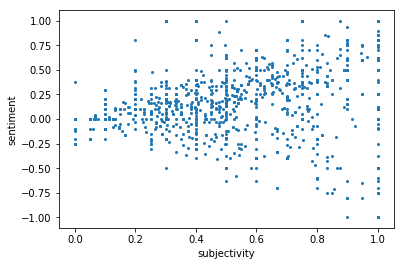

In [30]:
import matplotlib.pyplot as plt
plt.scatter(df['subjectivity'],df['my_polarity'],s=4)
plt.xlabel('subjectivity')
plt.ylabel('sentiment')
plt.show()

In [31]:
positives=df[df['sentiment']==1]['subjectivity'].astype(float)
negatives=df[df['sentiment']==-1]['subjectivity'].astype(float)

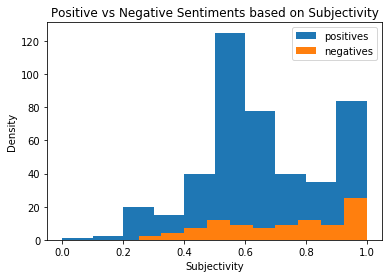

In [32]:
plt.hist(positives)
plt.hist(negatives)
plt.title('Positive vs Negative Sentiments based on Subjectivity')
plt.legend(['positives','negatives'])
plt.xlabel('Subjectivity')
plt.ylabel('Density')
plt.show()

(-0.5, 699.5, 399.5, -0.5)

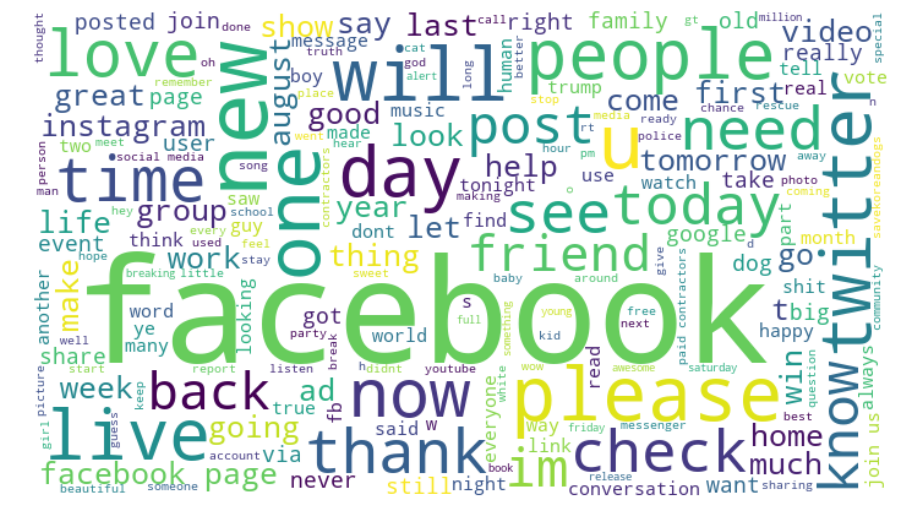

In [33]:
from wordcloud import WordCloud
words = ' '.join([word for word in df.text])
wordcloud = WordCloud(width=700, height=400, random_state=20, max_font_size=120, background_color="white").generate(words)
fig, ax = plt.subplots(figsize=(18,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

### As a conclusion, we can see that people more often tweet positive things according to their opeinions.

In [34]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_score

In [35]:
train_len=int(len(df)*0.8)+1
train_df=df[:train_len]
train_df

,id_str,text,created_at,polarity,user_location,subjectivity,my_polarity,sentiment
0,1161743655130058753,please use the trend on both twiter and faceb...,2019-08-14 20:57:26,0,"Malir Cantonment, Pakistan",0.000000,0.000000,0
1,1161743655713038340,vic is headed to recovery. took a bit longer ...,2019-08-14 20:57:26,0,"Walterboro, SC",0.300000,0.200000,0
2,1161743656056844288,i never experienced racism ; hatred until i v...,2019-08-14 20:57:26,0,"Tennessee, USA",0.383333,-0.050000,0
3,1161743656627396609,come see me tonight!,2019-08-14 20:57:26,0,Texas,0.000000,0.000000,0
4,1161743656786767873,"place to go,got an appt for tomorrow am to se...",2019-08-14 20:57:26,1,chattanooga tn,0.400000,0.350000,1
5,1161743657323679744,wow.. this hit d spot.. neededtoshare,2019-08-14 20:57:26,0,Trinidad&Tobago,1.000000,0.100000,0
6,1161743657524797441,saw this on facebook ; ill always respect cop...,2019-08-14 20:57:26,-1,"Palmdale, CA",0.950000,-0.650000,-1
7,1161743661018898440,the dj space performance video from iss of . ...,2019-08-14 20:57:27,0,NaN,0.250000,-0.150000,0
8,1161743662398787585,did mark zuckerberg lie under oath about face...,2019-08-14 20:57:27,0,USA,0.700000,-0.400000,-1
9,1161743664525111297,time for a revolution?,2019-08-14 20:57:28,0,"Nevada, USA",0.000000,0.000000,0


In [36]:
test_df=df[train_len:].reset_index(drop=True)
test_df

,id_str,text,created_at,polarity,user_location,subjectivity,my_polarity,sentiment
0,1161745180086743050,"common language draft of class action, and re...",2019-08-14 21:03:29,0,Danzig,0.300000,-0.100000,0
1,1161745180363558918,shit..gotta be cheaper than the damages!? im in!,2019-08-14 21:03:29,0,BAMA,0.000000,0.000000,0
2,1161745181781168128,"usa watch the video!mothers, gut-wrenching ...",2019-08-14 21:03:30,0,NaN,0.000000,0.000000,0
3,1161745185358909442,"""last christmas"" movie november 8featuring th...",2019-08-14 21:03:31,0,Europe,0.066667,0.000000,0
4,1161745185669308418,facebook is facing questions from ireland's d...,2019-08-14 21:03:31,0,NaN,0.050000,0.000000,0
5,1161745188865232896,politicians are not going to provide the most ...,2019-08-14 21:03:31,1,NaN,0.650000,0.550000,1
6,1161745189314138114,ha! dont be a dick!,2019-08-14 21:03:31,0,"Lousiville, KY",0.000000,0.000000,0
7,1161745189645553664,i have always fellshort of blaming some elites...,2019-08-14 21:03:32,0,South Sudan,0.450000,0.150000,0
8,1161745190253748224,dont understand these people who share stuff ...,2019-08-14 21:03:32,0,"Scotland, United Kingdom",0.000000,0.000000,0
9,1161745190912061445,"enjoy no, facebook isn't getting rid of your ...",2019-08-14 21:03:32,0,NaN,0.650000,0.266667,1


In [37]:
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(train_df.text)
X

<1565x5178 sparse matrix of type '<type 'numpy.float64'>'
	with 11528 stored elements in Compressed Sparse Row format>

In [38]:
X.shape

(1565, 5178)

In [39]:
classifier = OneVsOneClassifier(LinearSVC())

In [40]:
import numpy as np
scores = cross_val_score(classifier,X,y=train_df.sentiment,cv=10)
print "Average Accuracy: {}".format(np.mean(scores))

Average Accuracy: 0.794205316465


In [41]:
classifier.fit(X,train_df.sentiment)

OneVsOneClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=None)

In [42]:
classifier.classes_

array([-1,  0,  1])

In [43]:
X_validation=vectorizer.transform(test_df.text)

In [44]:
X_validation.shape

(390, 5178)

In [45]:
predicted=classifier.predict(X_validation)
predicted

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, -1,  0,  0,  1,
        1,  0,  1,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,
        0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0,
        0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0, -1,  0,  1,  0,  0,
        0,  1,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0,  1,
        0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  1